# Project 5: Automatic Image Caption (8K), Pre-Trained VGG16, RNNv2 (Dropout), TF1.5

## Import Libraries 

In [1]:
import numpy  as np
import pandas as pd
import os
import string
import re
import time
import pickle
#import tqdm
#from tqdm import tqdm
from tqdm.notebook       import tqdm
import matplotlib.pyplot as plt
import seaborn           as sns
import random

import tensorflow        as tf
import keras

from collections         import Counter, OrderedDict
from pickle              import dump

from nltk.translate.bleu_score         import sentence_bleu, SmoothingFunction

from keras                             import models,layers
from keras.preprocessing.image         import load_img, img_to_array
from keras.applications.vgg16          import preprocess_input,VGG16
from keras.preprocessing.text          import Tokenizer
from keras.applications.imagenet_utils import decode_predictions
from keras.preprocessing.sequence      import pad_sequences
from keras.utils                       import to_categorical,plot_model
from keras.callbacks                   import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
from keras.layers                      import Dropout
from keras                             import backend as K

from sklearn.model_selection           import train_test_split

#from numpy.random                      import seed

#from tensorflow                        import set_random_seed

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

exclude_punctuation = set(string.punctuation) 

Using TensorFlow backend.


In [2]:
# Lets check out versions for Tensorflow and Keras
print(tf.__version__)
print(keras.__version__)

1.15.0
2.2.4


In [3]:
# Set global parameters
SEED                    = 42   # Global seed

SEED1                   = 2019  # Random seed for train test split
SEED2                   = 2020  # Validation random seed

sample_test_size        = 0.2   # Sample set for testing
sample_val_size         = 0.25  # Sample set for validation

os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)             # random seed 
np.random.seed(SEED)          # numpy Python seed
tf.set_random_seed(SEED)      # TensorFlow random number

session_conf = tf.ConfigProto(intra_op_parallelism_threads=16, inter_op_parallelism_threads=16)
sess         = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

## Load Files

In [4]:
# For now we are working on the 8,000 image dataset only
# Specify file paths and names
text_dir  = './data/flickr08k/text/'
image_dir = './data/flickr08k/images/'

fname_text = text_dir + 'Flickr8k.token.txt'

# Now for image directory
#pics = os.listdir(image_dir)

#print(pics[0])

In [5]:
# Load text file containing descriptions of all images
file = open(fname_text, 'r')

# read all text
corpus = file.read()

# close the file
file.close()

print(corpus[0:550],'\n')
print('Length of entire corpus is',len(corpus))

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the stairs to her playhouse .
1000268201_693b08cb0e.jpg#4	A little girl in a pink dress going into a wooden cabin .
1001773457_577c3a7d70.jpg#0	A black dog and a spotted dog are fighting
1001773457_577c3a7d70.jpg#1	A black dog and a tri-colored dog playin 

Length of entire corpus is 3394868


So image names on the left and the initial caption on the right. There are 5 versions of captions already provided. Good to know that there are separators such as tabs, spaces and a next line. The entire length is 3,395,237 which is not very useful since it is one whole list. We will need to do editing here.

In [6]:
# Lets separate them 
# Create the empty text 
doc = []

# Temporary stop gap measure only for testing
#corpus = corpus[0:1000]

for line in corpus.split('\n'):
   
    temp1 = line.split('\t')
    
    # The below line is necessary to ensure that it only works
    # on one line at line at a time
    if len(temp1) < 2:
        continue
    
    temp2 = temp1[0].split('#')
        
    doc.append(temp2 + [temp1[1]])
    
    #print(doc)
    
    
df = pd.DataFrame(doc,columns=['filename','index','caption_raw'])

df.head(5)

,filename,index,caption_raw
0,1000268201_693b08cb0e.jpg,0,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,1,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,2,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,3,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,4,A little girl in a pink dress going into a woo...


In [7]:
df.info()

# But the total number of images should be around 8,000
print('\nShape of corpus dataframe:',df.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40455 entries, 0 to 40454
Data columns (total 3 columns):
filename       40455 non-null object
index          40455 non-null object
caption_raw    40455 non-null object
dtypes: object(3)
memory usage: 948.3+ KB

Shape of corpus dataframe: (40455, 3)


In [8]:
df.dropna()

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40455 entries, 0 to 40454
Data columns (total 3 columns):
filename       40455 non-null object
index          40455 non-null object
caption_raw    40455 non-null object
dtypes: object(3)
memory usage: 948.3+ KB


In [9]:
print('Number of unique files:',len(np.unique(df.filename.values)));

# Another sanity check
num_of_captions_per_file = 5

num_of_image_files = df.shape[0]/num_of_captions_per_file

print('\nSanity check again:',int(num_of_image_files))

Number of unique files: 8091

Sanity check again: 8091


## Clean Captions

OK, we are good as the number of images was actually only 8,092. So the number reported in the text file is indeed correct. However, now we have to clean the captions as these will be used for our end goal. The vocabulary here is based on the words that are available in the corpus. This is what we are going to work with for now. 

In [10]:
def clean_captions(text):
    
    # Lower case
    text = text.lower()
    
    # Remove spaces at the beginning and end
    text = text.strip()
    
    # Remove numbers
    text = re.sub("[^a-zA-Z]", " ", text)
    
    # Remove punctuation and symbols
    text = ''.join(ch for ch in text if ch not in exclude_punctuation)
    
    # Remove single or hanging letters
    text = ' '.join( [w for w in text.split() if len(w)>1] )
    
    return(text)


In [11]:
TEXT = df['caption_raw']

test_text = TEXT[16]

print('Original Text:',test_text)

print('\nCleaned Text :',clean_captions(test_text))

Original Text: A man lays on the bench to which a white dog is also tied .

Cleaned Text : man lays on the bench to which white dog is also tied


In [12]:
df['caption_clean'] = df['caption_raw'].apply(clean_captions)

In [13]:
df.head(5)

,filename,index,caption_raw,caption_clean
0,1000268201_693b08cb0e.jpg,0,A child in a pink dress is climbing up a set o...,child in pink dress is climbing up set of stai...
1,1000268201_693b08cb0e.jpg,1,A girl going into a wooden building .,girl going into wooden building
2,1000268201_693b08cb0e.jpg,2,A little girl climbing into a wooden playhouse .,little girl climbing into wooden playhouse
3,1000268201_693b08cb0e.jpg,3,A little girl climbing the stairs to her playh...,little girl climbing the stairs to her playhouse
4,1000268201_693b08cb0e.jpg,4,A little girl in a pink dress going into a woo...,little girl in pink dress going into wooden cabin


In [14]:
# This is to add a marker before and after the caption
def add_start_end_seq_token(captions):
    caps = []
    for txt in captions:
        txt = 'startseq ' + txt + ' endseq'
        caps.append(txt)
    return(caps)

df["caption_clean_seq"] = add_start_end_seq_token(df["caption_clean"])

df.head(15)

,filename,index,caption_raw,caption_clean,caption_clean_seq
0,1000268201_693b08cb0e.jpg,0,A child in a pink dress is climbing up a set o...,child in pink dress is climbing up set of stai...,startseq child in pink dress is climbing up se...
1,1000268201_693b08cb0e.jpg,1,A girl going into a wooden building .,girl going into wooden building,startseq girl going into wooden building endseq
2,1000268201_693b08cb0e.jpg,2,A little girl climbing into a wooden playhouse .,little girl climbing into wooden playhouse,startseq little girl climbing into wooden play...
3,1000268201_693b08cb0e.jpg,3,A little girl climbing the stairs to her playh...,little girl climbing the stairs to her playhouse,startseq little girl climbing the stairs to he...
4,1000268201_693b08cb0e.jpg,4,A little girl in a pink dress going into a woo...,little girl in pink dress going into wooden cabin,startseq little girl in pink dress going into ...
5,1001773457_577c3a7d70.jpg,0,A black dog and a spotted dog are fighting,black dog and spotted dog are fighting,startseq black dog and spotted dog are fightin...
6,1001773457_577c3a7d70.jpg,1,A black dog and a tri-colored dog playing with...,black dog and tri colored dog playing with eac...,startseq black dog and tri colored dog playing...
7,1001773457_577c3a7d70.jpg,2,A black dog and a white dog with brown spots a...,black dog and white dog with brown spots are s...,startseq black dog and white dog with brown sp...
8,1001773457_577c3a7d70.jpg,3,Two dogs of different breeds looking at each o...,two dogs of different breeds looking at each o...,startseq two dogs of different breeds looking ...
9,1001773457_577c3a7d70.jpg,4,Two dogs on pavement moving toward each other .,two dogs on pavement moving toward each other,startseq two dogs on pavement moving toward ea...


## Load & Modify VGG16 Model

We will load the VGG16 model first in its entirety and then chop off the classification layer since we only want to get features from all our images. We already have our weights downloaded so that we do not have to train them again. Below, we cannot just apply **False** to include top since we are also importing weights that have the weights for the final portion. 

In [15]:
model_cnn = VGG16(include_top=True,weights=None)

model_cnn.load_weights("./vgg16_weights_tf_dim_ordering_tf_kernels.h5")

model_cnn.summary()








_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
___

In [16]:
# Now remove the prediction layer of the modelfrom keras import models
model_cnn.layers.pop()

model_cnn = models.Model(inputs=model_cnn.inputs, outputs=model_cnn.layers[-1].output)

model_cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

## Feature Extraction using VGG16

In [17]:

pics_in = df['filename'].to_list()

#print(pics)

#print(dfff[0:1])

def f2(seq): 
    # order preserving
    checked = []
    for e in seq:
        if e not in checked:
            checked.append(e)
    return checked

pics = f2(pics_in)

print(len(pics))

8091


In [18]:
'''
# Grab features from images using modified/truncated model
# Taken from 
# https://fairyonice.github.io/Develop_an_image_captioning_deep_learning_model_using_Flickr_8K_data.html
features    = OrderedDict()
npix        = 224             # This is the default input size for VGG16
target_size = (npix,npix,3)   # Set size for VGG16 model

# name is the image name of file name specifically

pbar = tqdm(pics)

for iname in pbar:
    # Load an image from file
    filename = image_dir + '/' + iname
    image    = load_img(filename, target_size=target_size)
    
    # Convert the image pixels to a numpy array
    image = img_to_array(image)
    
    # Reshape data for the model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    
    # prepare the image for the modified VGG model
    image = preprocess_input(image)
    
    # Extract feature by making the prediction on the image
    feature = model_cnn.predict(image, verbose=0)
    
    features[iname] = feature.flatten()
    
    
# Looks like there are 8,091 images
#''';

In [19]:
# Save to a file for future use
#dump(features, open('features_8k.pkl', 'wb'))

In [20]:
# Open if needed
features = pickle.load(open('features_8k.pkl', "rb" ))

## Tokenize Captions

In [21]:
# Here the first caption i.e., caption 0 is chosen. There is no reason why zero is chosen.
# One can also choose 1 through 4.
index_caption_value = 0

dimages, keepindex = [],[]

df_txt = df.loc[df["index"].values == str(index_caption_value),: ]

#print(df_txt)

for i, fnm in enumerate(df_txt.filename):
    if fnm in features.keys(): 
        dimages.append(features[fnm])
        keepindex.append(i)

# Convert to numpy array
fnames    = df_txt['filename'].iloc[keepindex].values
dcaptions = df_txt['caption_clean_seq'].iloc[keepindex].values
dimages   = np.array(dimages)

#print(dcaptions)
#print(dimages)

In [22]:
df_txt.head(10)

,filename,index,caption_raw,caption_clean,caption_clean_seq
0,1000268201_693b08cb0e.jpg,0,A child in a pink dress is climbing up a set o...,child in pink dress is climbing up set of stai...,startseq child in pink dress is climbing up se...
5,1001773457_577c3a7d70.jpg,0,A black dog and a spotted dog are fighting,black dog and spotted dog are fighting,startseq black dog and spotted dog are fightin...
10,1002674143_1b742ab4b8.jpg,0,A little girl covered in paint sits in front o...,little girl covered in paint sits in front of ...,startseq little girl covered in paint sits in ...
15,1003163366_44323f5815.jpg,0,A man lays on a bench while his dog sits by him .,man lays on bench while his dog sits by him,startseq man lays on bench while his dog sits ...
20,1007129816_e794419615.jpg,0,A man in an orange hat starring at something .,man in an orange hat starring at something,startseq man in an orange hat starring at some...
25,1007320043_627395c3d8.jpg,0,A child playing on a rope net .,child playing on rope net,startseq child playing on rope net endseq
30,1009434119_febe49276a.jpg,0,A black and white dog is running in a grassy g...,black and white dog is running in grassy garde...,startseq black and white dog is running in gra...
35,1012212859_01547e3f17.jpg,0,"A dog shakes its head near the shore , a red b...",dog shakes its head near the shore red ball ne...,startseq dog shakes its head near the shore re...
40,1015118661_980735411b.jpg,0,A boy smiles in front of a stony wall in a city .,boy smiles in front of stony wall in city,startseq boy smiles in front of stony wall in ...
45,1015584366_dfcec3c85a.jpg,0,A black dog leaps over a log .,black dog leaps over log,startseq black dog leaps over log endseq


In [23]:
print(len(fnames))
print(type(fnames))

8091
<class 'numpy.ndarray'>


In [61]:
# The Keras Tokenizer class to consistently map each word in 
# the vocabulary to an integer. First, the object is created, then is fit 
# on the description text. The fit tokenizer can later be saved to file 
# for consistent decoding of the predictions back to vocabulary words.

nb_words = 10000 # Max number of words in our vocabulary

# Keras tokenizer
tokenizer = Tokenizer(num_words=nb_words)

tokenizer.fit_on_texts(dcaptions)

dump(tokenizer, open('tokenizer_8k.pkl', 'wb'))

vocab_size = len(tokenizer.word_index) + 1  # Why is this plus 1?

print("vocabulary size : {}".format(vocab_size))

# integer encode descriptions
dtexts = tokenizer.texts_to_sequences(dcaptions)

#print(dtexts)

#print(type(dtexts[:5]))
#print(dtexts)

vocabulary size : 4398


In [25]:
'''
# Train test split data
prop_test, prop_val = 0.2, 0.2 

N = len(dtexts)
Ntest, Nval = int(N*prop_test), int(N*prop_val)

def split_test_val_train(dtexts,Ntest,Nval):
    return(dtexts[:Ntest], 
           dtexts[Ntest:Ntest+Nval],  
           dtexts[Ntest+Nval:])

temp_text_test,  temp_text_val,  temp_text_train  = split_test_val_train(dtexts,Ntest,Nval)
temp_image_test, temp_image_val, temp_image_train = split_test_val_train(dimages,Ntest,Nval)
temp_fname_test, temp_fname_val, temp_fname_train = split_test_val_train(fnames,Ntest,Nval)
''';

## Train-Test Split (Train, Validation, Test)

In [26]:

# Split texts
dtext_train, dtext_test = train_test_split(dtexts, 
                                           test_size=sample_test_size, 
                                           random_state=2019)

dtext_train, dtext_val  = train_test_split(dtext_train, 
                                           test_size=sample_val_size, 
                                           random_state=2020)


# Split images
dimage_train, dimage_test = train_test_split(dimages, 
                                             test_size=sample_test_size, 
                                             random_state=2019)

dimage_train, dimage_val  = train_test_split(dimage_train, 
                                             test_size=sample_val_size, 
                                             random_state=2020)


# Split file names
dfname_train, dfname_test = train_test_split(fnames, 
                                             test_size=sample_test_size, 
                                             random_state=2019)

dfname_train, dfname_val  = train_test_split(dfname_train, 
                                             test_size=sample_val_size, 
                                             random_state=2020)
                                                     


In [84]:
print(dfname_train[0:20])

['2060031241_a3ae7a06bb.jpg' '2097398349_ff178b3f1b.jpg'
 '394136487_4fc531b33a.jpg' '1523800748_a59e980eee.jpg'
 '521658170_a837af87e9.jpg' '309238565_2d5d8dc8bf.jpg'
 '3283368342_b96d45210e.jpg' '636503038_17ca82b50f.jpg'
 '2268729848_d418451226.jpg' '2842439618_fb20fe2215.jpg'
 '1338523142_57fce8229b.jpg' '539744890_85e63f5854.jpg'
 '2579899436_5086a33c7a.jpg' '2490179961_e842fda5eb.jpg'
 '616177206_0e16c33f6b.jpg' '3304484212_b950233c30.jpg'
 '2505988632_9541f15583.jpg' '136644885_f7d2bbf546.jpg'
 '3246773992_89bf86937b.jpg' '460973814_5eacd1ced4.jpg']


In [86]:
#print(dtext_train[0:20])

In [28]:
#print(type(X_train))
print(len(dtext_test),len(dtext_val),len(dtext_train))

1619 1618 4854


In [29]:
# This is to find the maximum length of captions. It is a set size.
maxlen = np.max([len(text) for text in dtexts])

print(maxlen)

30


In [58]:
def preprocessing(dtexts,dimages):
    N = len(dtexts)
    
    print("# captions/images = {}".format(N))

    # Check that there are captions for the image before proceeding
    assert(N == len(dimages))
    
    X_text, X_image, y_text = [],[],[]
    
    for text,image in zip(dtexts,dimages):
        for i in range(1,len(text)):
            
            in_text, out_text = text[:i], text[i]
            
            in_text  = pad_sequences([in_text],maxlen=maxlen).flatten()
            out_text = to_categorical(out_text,num_classes = vocab_size)
            
            #print(out_text)

            X_text.append(in_text)
            X_image.append(image)
            y_text.append(out_text)

    X_text  = np.array(X_text)
    X_image = np.array(X_image)
    y_text  = np.array(y_text)
    
    print(" {} {} {}".format(X_text.shape,X_image.shape,y_text.shape))
    
    return(X_text,X_image,y_text)



In [59]:
#print()

In [60]:
X_text_train, X_image_train, y_text_train = preprocessing(dtext_train,dimage_train)
X_text_val,   X_image_val,   y_text_val   = preprocessing(dtext_val,dimage_val)

# captions/images = 4854
 (49809, 30) (49809, 4096) (49809, 4398)
# captions/images = 1618
 (16540, 30) (16540, 4096) (16540, 4398)


## Setup Recurrent Neural Network (RNN) For Text 

In [32]:
# Nice model from 
# RNNv2 includes Dropout layer in hopes of making it more robust
# Adapted from 
# https://machinelearningmastery.com/develop-a-deep-learning-caption-generation-model-in-python/

#print(vocab_size)
## image feature

dim_embedding = 64
dropout_val   = 0.5

# Feature extractor model
inputs1 = layers.Input(shape=(X_image_train.shape[1],))
fe1     = layers.Dropout(dropout_val,seed=42)(inputs1)
fe2     = layers.Dense(256,activation='relu',name="ImageFeature")(fe1)

# Sequence model
inputs2 = layers.Input(shape=(maxlen,))
se1     = layers.Embedding(vocab_size,dim_embedding, mask_zero=True)(inputs2)
se2     = layers.Dropout(dropout_val,seed=45)(se1)
se3     = layers.LSTM(256,name="CaptionFeature")(se2)

## Now combine feature extractor and sequencer to create decoder
decoder1 = layers.add([fe2,se3])
decoder2 = layers.Dense(256,activation='relu')(decoder1)
outputs  = layers.Dense(vocab_size,activation='softmax')(decoder2)

# Compile the model
model_rnn = models.Model(inputs=[inputs1, inputs2],outputs=outputs)

# Might have to change this  
model_rnn.compile(loss='categorical_crossentropy', optimizer='adam')

model_rnn.summary()

plot_model(model_rnn, to_file='./rnn_model.png', show_shapes=True)

'''
Give this a shot later...

Found another potential option for the loss and optimizer

optimizer = RMSprop(lr=1e-3)

decoder_target = tf.placeholder(dtype='int32', shape=(None, None))


decoder_model.compile(optimizer=optimizer,
                      loss=sparse_cross_entropy,
                      target_tensors=[decoder_target])
                      
''';


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 30)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 4096)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 30, 64)       281472      input_3[0][0]                    
_______________________________________________________________________________________________

## Train RNN

In [33]:
# Model training
# fit model
num_epochs = 10
batch_size = 512

# Save best model for later use
filepath = './checkpoints/model-rnn-v2-8k-ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5'

earlyStopping  = EarlyStopping(monitor='val_loss', patience=0, verbose=0, mode='min')
checkpoints    = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, epsilon=1e-4, mode='min')

start = time.time()

model_fit = model_rnn.fit([X_image_train, X_text_train], y_text_train, 
                           epochs = num_epochs, verbose=2, 
                           batch_size = batch_size,
                           callbacks=[earlyStopping, checkpoints, reduce_lr_loss],
                           validation_data=([X_image_val, X_text_val], y_text_val))
end = time.time()

print("\nTIME TOOK {:3.2f}MIN".format((end - start )/60))


/Users/phoitack/anaconda3/envs/metis/lib/python3.7/site-packages/keras/callbacks.py:1065: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '




Train on 49809 samples, validate on 16540 samples
Epoch 1/10
 - 28s - loss: 5.7659 - val_loss: 5.3267

Epoch 00001: val_loss improved from inf to 5.32671, saving model to ./checkpoints/model-rnn-v2-8k-ep001-loss5.766-val_loss5.327.h5
Epoch 2/10
 - 30s - loss: 4.9860 - val_loss: 5.0185

Epoch 00002: val_loss improved from 5.32671 to 5.01849, saving model to ./checkpoints/model-rnn-v2-8k-ep002-loss4.986-val_loss5.018.h5
Epoch 3/10
 - 31s - loss: 4.4777 - val_loss: 4.7295

Epoch 00003: val_loss improved from 5.01849 to 4.72951, saving model to ./checkpoints/model-rnn-v2-8k-ep003-loss4.478-val_loss4.730.h5
Epoch 4/10
 - 31s - loss: 3.9937 - val_loss: 4.5663

Epoch 00004: val_loss improved from 4.72951 to 4.56633, saving model to ./checkpoints/model-rnn-v2-8k-ep004-loss3.994-val_loss4.566.h5
Epoch 5/10
 - 33s - loss: 3.6023 - val_loss: 4.5043

Epoch 00005: val_loss improved from 4.56633 to 4.50426, saving model to ./checkpoints/model-rnn-v2-8k-ep005-loss3.602-val_loss4.504.h5
Epoch 6/10
 

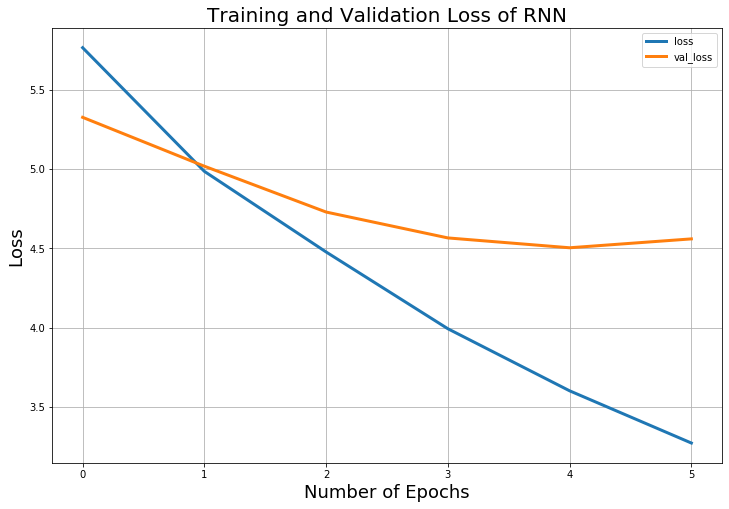

In [64]:
plt.figure(figsize=(12, 8))
for label in ["loss","val_loss"]:
    plt.plot(model_fit.history[label],label=label,linewidth=3)
plt.legend()
plt.title('Training and Validation Loss of RNN', fontsize=20)
plt.grid()
plt.xlabel("Number of Epochs", fontsize=18)
plt.ylabel("Loss", fontsize=18)
plt.savefig('./loss_val_loss_vs_epochs_rnnv2_8k.svg')
plt.show();

## Predict Captions

In [69]:
index_word = dict([(index,word) for word, index in tokenizer.word_index.items()])

#print(index_word)

def predict_caption(image_feat):
    
    in_text = "startseq"

    for i_word in range(maxlen):
        
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence],maxlen)
        
        #print(sequence)
        
        # The prediction portion
        yhat = model_rnn.predict([image_feat,sequence],verbose=0)
        
        #print(yhat)
        yhat = np.argmax(yhat)    # Get index where yhat is max
        
        new_word = index_word[yhat]
        in_text += " " + new_word

        # if the next word starts with endseq then get out of the loop
        # and return 
        if new_word == "endseq":
            break
            
    return(in_text)

3495490064_8db40a83af.jpg
2226587791_66e29dd01d.jpg
3564742915_5f940b95b4.jpg
3431261634_c73360406a.jpg
2932740428_b15384f389.jpg
3582689770_e57ab56671.jpg
872135364_8c1e47d163.jpg
1539166395_0cdc0accee.jpg
3515451715_ac5ac04efa.jpg
3519155763_045a6a55e2.jpg
2444741900_5cb3ef3e1d.jpg
2766726291_b83eb5d315.jpg
2694890967_7c7a89de16.jpg
2521938802_853224f378.jpg
2519483556_2b1632a18c.jpg
2322334640_d4d22619ff.jpg
3271468462_701eb88d3b.jpg
557601144_50b8c40393.jpg
241347580_a1e20321d3.jpg
771048251_602e5e8f45.jpg


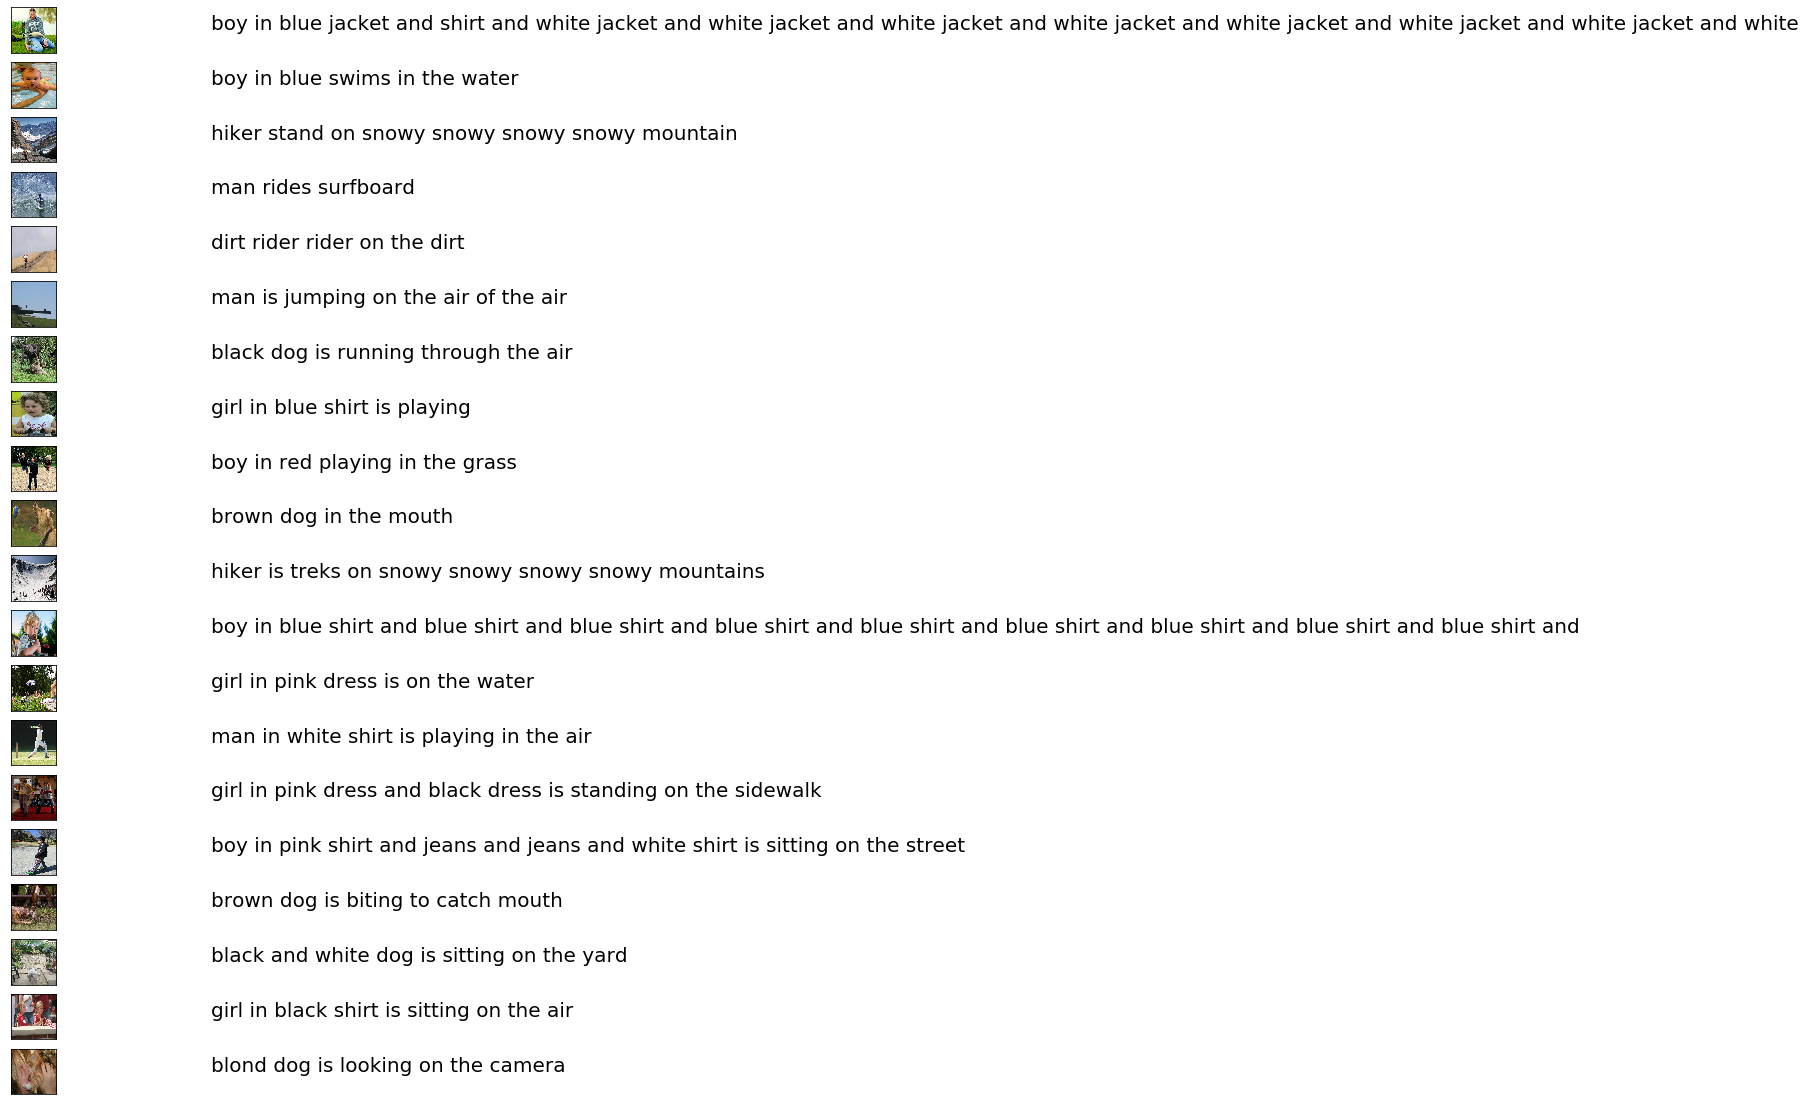

In [87]:
npic = 20
npix = 224
target_size = (npix,npix,3)

count = 1
fig = plt.figure(figsize=(10,20))

for picfile, image_feature in zip(dfname_test[:npic],dimage_test[:npic]):
    ## images 
    print(picfile)
    filename = image_dir + '/' + picfile
    image_load = load_img(filename, target_size=target_size)
    ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
    ax.imshow(image_load)
    count = count + 1
    
    #print(image_feature[0:10])

    ## captions
    caption = predict_caption(image_feature.reshape(1,len(image_feature)))
    caption = ' '.join(caption.split()[1:-1])
    
    ax = fig.add_subplot(npic,2,count)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ax.text(0,0.5,caption,fontsize=20)
    count = count + 1
    
    #print(len(caption.split()))

plt.show()

#print((caption))

## BLEU Metric

Taken from Wikipedia:

BLEU (bilingual evaluation understudy) is an algorithm for evaluating the quality of text which has been machine-translated from one natural language to another. Quality is considered to be the correspondence between a machine's output and that of a human: "the closer a machine translation is to a professional human translation, the better it is" – this is the central idea behind BLEU.[1][2] BLEU was one of the first metrics to claim a high correlation with human judgements of quality,[3][4] and remains one of the most popular automated and inexpensive metrics.

In [73]:
#'''
nkeep = 5
pred_good, pred_bad, bleus = [], [], [] 
count = 0 

for image_filename, image_feature, tokenized_text in zip(dfname_test,dimage_test,dtext_test):
    count += 1
    if count % 200 == 0:
        print("  {:4.2f}% is done..".format(100*count/float(len(dfname_test))))
    
    caption_true = [ index_word[i] for i in tokenized_text ]
    caption_true = caption_true[1:-1] ## remove startseq, and endseq
    
    ## captions
    caption = predict_caption(image_feature.reshape(1,len(image_feature)))
    caption = caption.split()
    caption = caption[1:-1]   ## remove startreg, and endreg
    
    sf = SmoothingFunction().method5
    
    bleu = sentence_bleu([caption_true],caption,smoothing_function = sf)
    bleus.append(bleu)
    
    if bleu > 0.6 and len(pred_good) < nkeep:
        pred_good.append((bleu,image_filename,caption_true,caption))
    elif bleu < 0.3 and len(pred_bad) < nkeep:
        pred_bad.append((bleu,image_filename,caption_true,caption))
#''';

  12.35% is done..
  24.71% is done..
  37.06% is done..
  49.41% is done..
  61.77% is done..
  74.12% is done..
  86.47% is done..
  98.83% is done..


In [38]:
print(' '.join(pred_good[0][3]))

Good Caption
733752482_ee01a419e5.jpg
421153376_d1d325568f.jpg
456512643_0aac2fa9ce.jpg
1119418776_58e4b93eac.jpg
421932359_edbf181f44.jpg


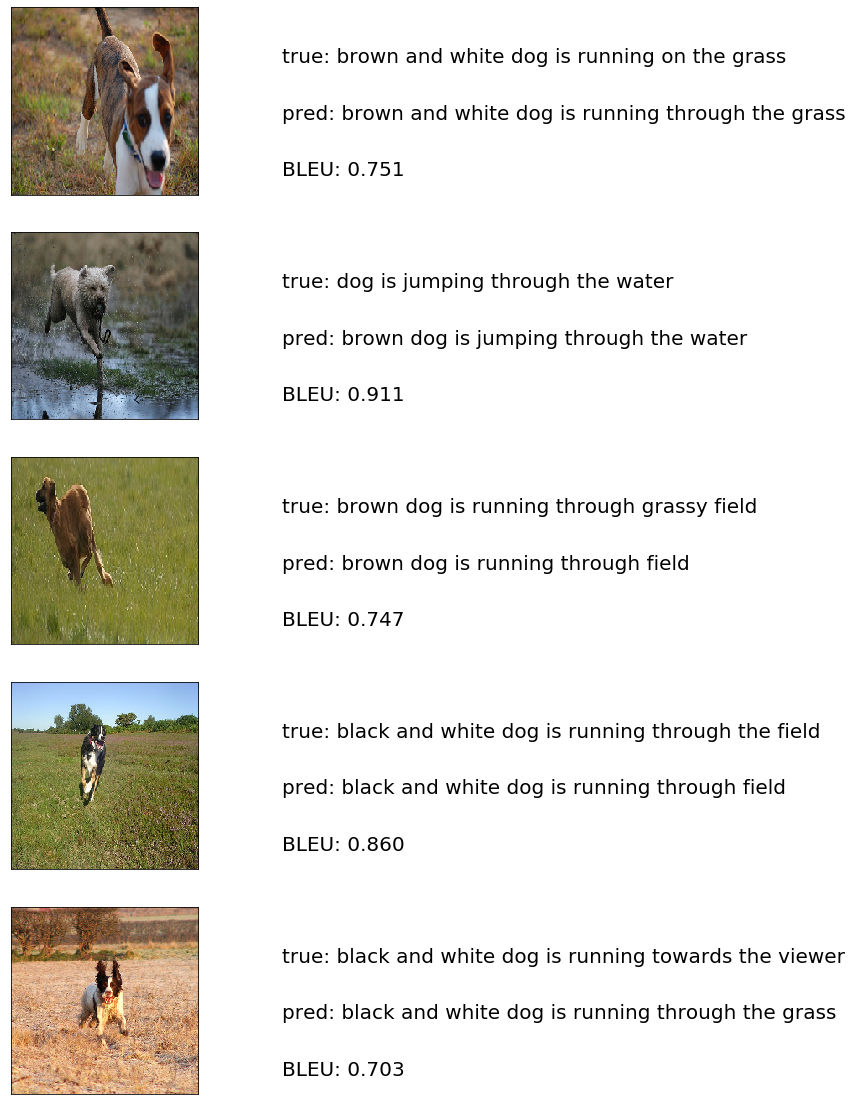

In [75]:
#'''
def plot_images(pred_pic):
    
    # Join tokenized string back again
    def create_str(caption_true):
        strue = ""
        for s in caption_true:
            strue += " " + s
        return(strue)
    
    npix = 224
    target_size = (npix,npix,3)    
    count = 1
    #fig = plt.figure(figsize=(10,20))
    npic = len(pred_pic)
    
    fig = plt.figure(figsize=(10,20))
    
    for pp in pred_pic:
        bleu,jpgfnm,caption_true,caption = pp
        ## images 
        filename = image_dir + '/' + jpgfnm
        print(jpgfnm)
        image_load = load_img(filename, target_size=target_size)
        ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
        ax.imshow(image_load)
        count += 1

        caption_true = create_str(caption_true)
        caption = create_str(caption)
        
        ax = fig.add_subplot(npic,2,count)
        plt.axis('off')
        ax.plot()
        ax.set_xlim(0,1)
        ax.set_ylim(0,1)
        ax.text(0,0.7,"true:" + caption_true,fontsize=20)
        ax.text(0,0.4,"pred:" + caption,fontsize=20)
        ax.text(0,0.1,"BLEU: {:0.3f}".format(bleu),fontsize=20)
        count += 1
    plt.show()

#print("Bad Caption")
#plot_images(pred_bad)
print("Good Caption")
plot_images(pred_good)
#''';

In [40]:
'''
# Alternate way of showing the image
# Image that was captured above a BLEU score of 0.7: 486917990_72bd4069af.jpg
filename_good = './data/flickr08k/images/486917990_72bd4069af.jpg'
image_load = load_img(filename_good, target_size=target_size)
#ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
plt.imshow(image_load);

dfp = df.loc[df['filename']=='486917990_72bd4069af.jpg',['caption_clean_seq']]

dfp = dfp.iloc[0,0]

dfp

#print(caption_true)

#print('True Caption:',)
''';

In [41]:
#print(pred_good)
#print(pred_good[0][2])

## Text-to-Speech

In [42]:
'''
# Import the required module for text  
# to speech conversion 
from gtts import gTTS 
  
# This module is imported so that we can  
# play the converted audio (already imported)
# import os 
  
# The text that you want to convert to audio 
mytext = ' '.join(pred_good[0][2])
  
# Language in which you want to convert 
language = 'en'
  
# Passing the text and language to the engine,  
# here we have marked slow=False. Which tells  
# the module that the converted audio should  
# have a high speed 
myobj = gTTS(text=mytext, lang=language, slow=False) 
  
# Saving the converted audio in a mp3 file named 
# welcome  
myobj.save("predicted_test.mp3") 
''';

In [43]:
# Playing the converted file 
#os.system("open predicted_test.mp3")

In [48]:
# Re-test for the first pic

img_file = './data/flickr08k/images/2226587791_66e29dd01d.jpg'

imagex    = load_img(img_file, target_size=target_size)
imagex    = img_to_array(imagex)
imagex    = imagex.reshape((1, imagex.shape[0], imagex.shape[1], imagex.shape[2]))
imagex    = preprocess_input(imagex)

featurex  = model_cnn.predict(imagex, verbose=0)
featuresx = featurex.flatten()

print(featuresx[0:15])

[0.         0.         1.4008057  0.         0.         0.
 0.         8.35526    3.1953115  3.5485735  0.         0.
 0.07915658 0.         0.        ]


In [49]:
captionx = predict_caption(featuresx.reshape(1,len(featuresx)))
captionx = ' '.join(captionx.split()[1:-1])

boy in blue swims in the water


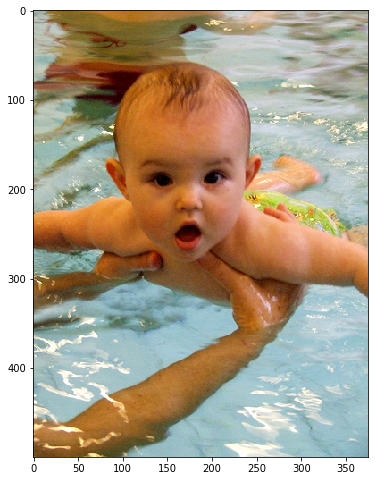

In [50]:
image_load = load_img(img_file)

fig = plt.figure(figsize=(6,12))
plt.imshow(image_load)

print(captionx)

In [82]:
L = "Boy is playing on the the water"
L = "Boy in blue jacket and white shirt and white shirt and white shirt"

#words = L.split()

print(' '.join(OrderedDict((w,w) for w in L.split()).keys()))

Boy in blue jacket and white shirt


In [80]:
print(set(L.split()))

{'Boy', 'on', 'playing', 'is', 'the', 'water'}
